In [2]:
!pip install prophet


  Using cached prophet-1.2.1-py3-none-win_amd64.whl.metadata (3.6 kB)
  Using cached cmdstanpy-1.3.0-py3-none-any.whl.metadata (4.2 kB)
  Using cached holidays-0.84-py3-none-any.whl.metadata (50 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached stanio-0.5.1-py3-none-any.whl.metadata (1.6 kB)
Using cached prophet-1.2.1-py3-none-win_amd64.whl (12.1 MB)
Using cached cmdstanpy-1.3.0-py3-none-any.whl (99 kB)
Using cached holidays-0.84-py3-none-any.whl (1.3 MB)
Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)
Using cached stanio-0.5.1-py3-none-any.whl (8.1 kB)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

plt.style.use("seaborn-v0_8")


In [8]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
features = pd.read_csv("features.csv")
stores = pd.read_csv("stores.csv")

train.head()
test.head()


,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [10]:
train["Date"] = pd.to_datetime(train["Date"])
test["Date"] = pd.to_datetime(test["Date"])
features["Date"] = pd.to_datetime(features["Date"])


train = train.merge(features, on=["Store", "Date", "IsHoliday"], how="left")
train = train.merge(stores, on="Store", how="left")

train.fillna(0, inplace=True)
train.head()



,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,A,151315


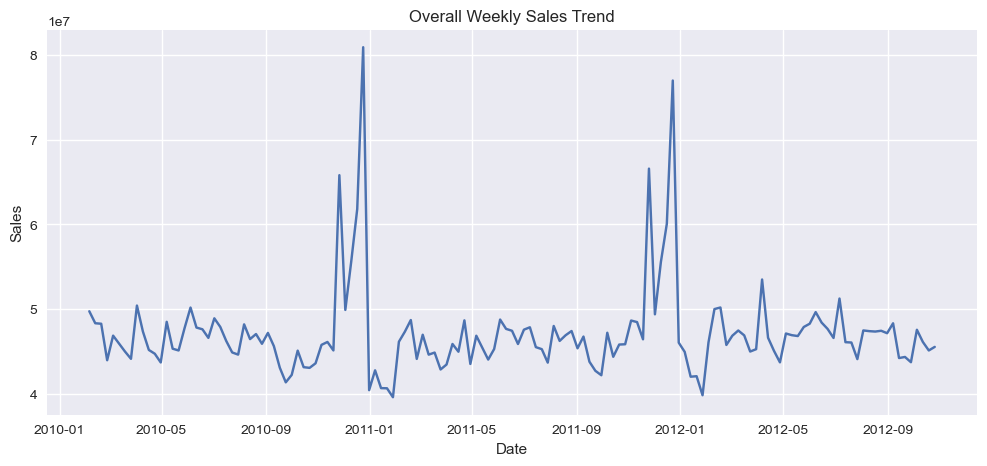

In [11]:
ts = train.groupby("Date")["Weekly_Sales"].sum()

plt.figure(figsize=(12,5))
plt.plot(ts)
plt.title("Overall Weekly Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


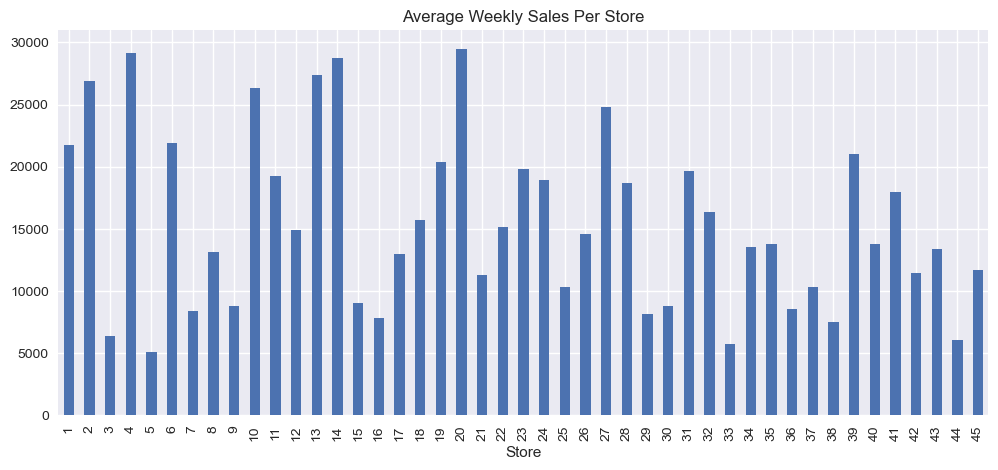

In [12]:
store_sales = train.groupby("Store")["Weekly_Sales"].mean()

plt.figure(figsize=(12,5))
store_sales.plot(kind="bar")
plt.title("Average Weekly Sales Per Store")
plt.show()


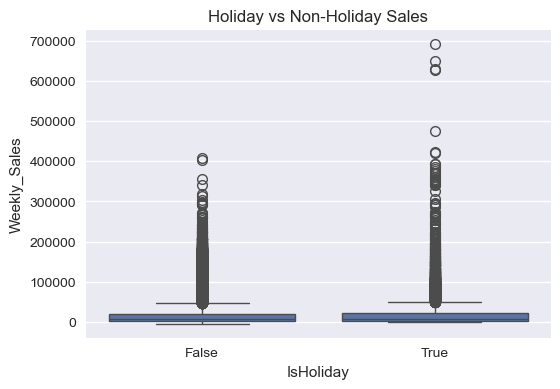

In [13]:
plt.figure(figsize=(6,4))
sns.boxplot(data=train, x="IsHoliday", y="Weekly_Sales")
plt.title("Holiday vs Non-Holiday Sales")
plt.show()


In [14]:
df = train.groupby("Date")["Weekly_Sales"].sum().reset_index()
df.columns = ["ds", "y"]

df.head()


,ds,y
0,2010-02-05,49750740.50
1,2010-02-12,48336677.63
2,2010-02-19,48276993.78
3,2010-02-26,43968571.13
4,2010-03-05,46871470.30


In [15]:
model = Prophet()
model.fit(df)


17:30:22 - cmdstanpy - INFO - Chain [1] start processing
17:30:22 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
future = model.make_future_dataframe(periods=12, freq="W")
forecast = model.predict(future)

forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()


,ds,yhat,yhat_lower,yhat_upper
150,2012-12-16,6.470881e+07,6.027633e+07,6.914965e+07
151,2012-12-23,6.353639e+07,5.944581e+07,6.784311e+07
152,2012-12-30,5.611697e+07,5.193093e+07,6.013636e+07
153,2013-01-06,4.602424e+07,4.167962e+07,5.065231e+07
154,2013-01-13,3.923576e+07,3.490575e+07,4.377585e+07


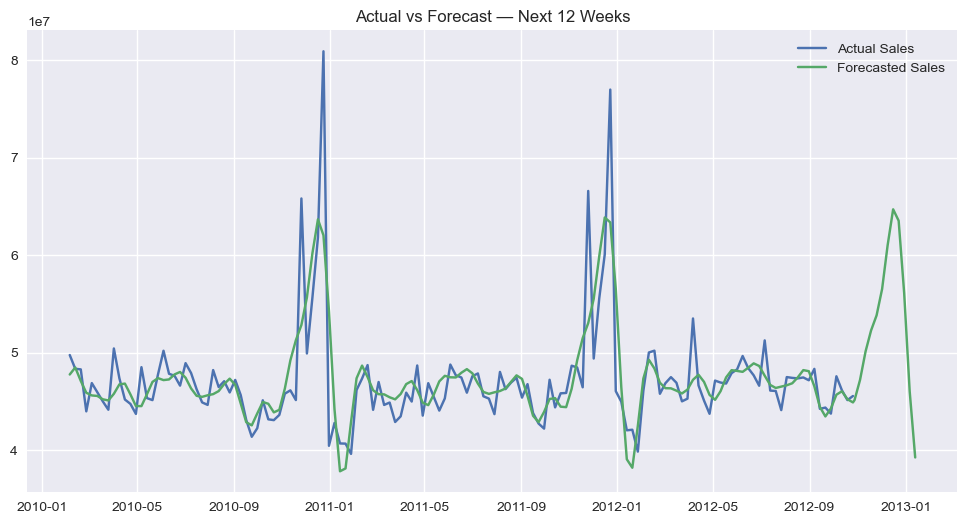

In [17]:
plt.figure(figsize=(12,6))
plt.plot(df["ds"], df["y"], label="Actual Sales")
plt.plot(forecast["ds"], forecast["yhat"], label="Forecasted Sales")

plt.title("Actual vs Forecast — Next 12 Weeks")
plt.legend()
plt.show()


In [18]:
# Split last 12 weeks as test, rest as train
train_size = len(df) - 12
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]


In [19]:
model = Prophet()
model.fit(train_df)


17:49:10 - cmdstanpy - INFO - Chain [1] start processing
17:49:10 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
future = model.make_future_dataframe(periods=12, freq="W")
forecast = model.predict(future)

# Sirf test period ka forecast
forecast_test = forecast.iloc[-12:]
forecast_test = forecast_test[["ds", "yhat"]].reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE
mae = mean_absolute_error(test_df["y"], forecast_test["yhat"])
# RMSE
rmse = mean_squared_error(test_df["y"], forecast_test["yhat"], squared=False)
# MAPE
mape = np.mean(np.abs((test_df["y"] - forecast_test["yhat"]) / test_df["y"])) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE: 952788.29
RMSE: 1222018.30
MAPE: 2.06%


C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


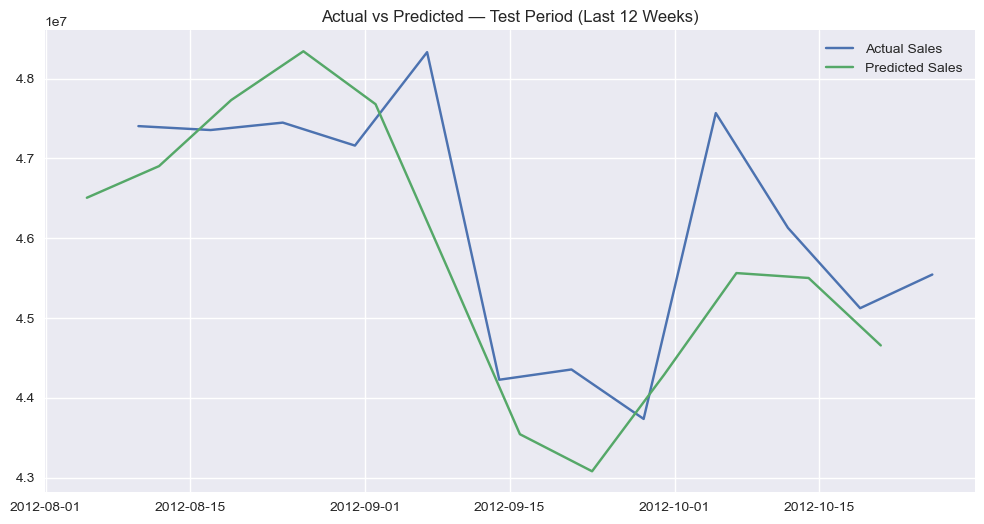

In [22]:
plt.figure(figsize=(12,6))
plt.plot(test_df["ds"], test_df["y"], label="Actual Sales")
plt.plot(forecast_test["ds"], forecast_test["yhat"], label="Predicted Sales")
plt.title("Actual vs Predicted — Test Period (Last 12 Weeks)")
plt.legend()
plt.show()
